In [ ]:
%load_ext autoreload
%autoreload 2

%cd '..'

In [ ]:
import logging
import sys

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[
        logging.FileHandler(f"data/logs/elections_polarization.log"),
        logging.StreamHandler(stream=sys.stdout),
    ],
)


In [ ]:
import json

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm  # type: ignore
from scipy import stats
import statsmodels.api as sm

sns.set_theme()

from eda.constants import (
    FIGURES_DIR,
)
from eda.utils import (
    plot_polarization_by_time,
    plot_nr_users_by_time,
)
from polarization.utils import (
    calculate_polarization,
    calculate_polarization_by_time,
)
from preprocessing.utils import (
    load_event_comments,
    load_event_vocab,
)
from preprocessing.constants import (
    OUTPUT_DIR,
)
from events.elections_constants import (
    ELECTIONS_EVENTS_INFO,
)
from eda.constants import (
    PARTIES_COLORS,
)


In [ ]:
YEAR = 2016
EVENT_KEY = f"us_elections_{YEAR}"
EVENT_DETAILS = ELECTIONS_EVENTS_INFO[EVENT_KEY]

logging.info(EVENT_DETAILS)


In [ ]:
logging.info(EVENT_DETAILS["name"])

event_comments = load_event_comments(theme="elections", event_name=EVENT_KEY)
event_vocab = load_event_vocab(theme="elections", event_name=EVENT_KEY)


In [ ]:
logging.info(event_comments.shape)
logging.info(event_comments.columns)


In [ ]:
plt.figure(figsize=(20, 12))
sns.countplot(
    y="subreddit",
    data=event_comments,
    hue="party",
    order=event_comments["subreddit"].value_counts().iloc[:20].index,
    palette=PARTIES_COLORS,
)

# rename labels in legend
plt.legend(
    title="Party",
    labels=["Democrat", "Republican"],
)

plt.xlabel("Number of comments")
plt.ylabel("Subreddit")

plt.savefig(
    fname=f"{FIGURES_DIR}/{EVENT_KEY}_subreddit_hist.pdf",
    bbox_inches="tight",
    pad_inches=0,
    format="pdf",
)
plt.show()


In [ ]:
event_comments["party"].value_counts() / event_comments.shape[0]


In [ ]:
plt.figure(figsize=(6, 2))
sns.countplot(y=event_comments["party"])

plt.savefig(
    fname=f"{FIGURES_DIR}/{EVENT_KEY}_party_hist.pdf",
    bbox_inches="tight",
    pad_inches=0,
    format="pdf",
)

plt.show()


In [ ]:
logging.info(event_comments.shape)


## Filter users

In [ ]:
# MAY_1_2016_TIMESTAMP = 1462060800

# early_comments = event_comments[event_comments["created_utc"] <= MAY_1_2016_TIMESTAMP]

# early_unique_users = early_comments["author"].unique()

# logging.info(early_unique_users.shape)

# event_comments["is_before_may_1"] = event_comments["author"].isin(early_unique_users)

# logging.info(event_comments.shape)


In [ ]:
logging.info(event_comments.shape)
logging.info(event_comments.columns)


### Total polarization

In [ ]:
logging.info("Calculating leave-out polarization...")

event_polarization = calculate_polarization(
    event_comments,
    ngram_range=(1, 2),
    event_vocab=event_vocab,
    method="leaveout",
    equalize_users=True,
)

logging.info("Saving leave-out polarization...")
with open(f"{OUTPUT_DIR}/{EVENT_KEY}_leaveout_polarization.json", "w") as file:
    json.dump(event_polarization, file)


In [ ]:
event_polarization = json.load(
    open(
        f"{OUTPUT_DIR}/{EVENT_KEY}_leaveout_polarization.json",
    )
)


In [ ]:
total_pol, (dem_polarization, rep_polarization) = event_polarization

logging.info(f"Total polarization: {total_pol}")
logging.info(f"Democrat mean polarization: {np.mean(dem_polarization)}")
logging.info(f"Republican mean polarization: {np.mean(rep_polarization)}")


In [ ]:
t = stats.ttest_ind(dem_polarization, rep_polarization, equal_var=False)

logging.info(t)


In [ ]:
# Plot user polarization

user_pols = pd.DataFrame(
    zip(
        dem_polarization + rep_polarization,
        ["Democrat"] * len(dem_polarization) + ["Republican"] * len(dem_polarization),
    ),
    columns=["Polarization", "Party"],
)

plt.figure(figsize=(15, 2))

ax = sns.violinplot(
    data=user_pols,
    x="Polarization",
    y="Party",
    hue="Party",
    palette=PARTIES_COLORS,
)

ax.get_yaxis().set_ticks([])
ax.set_ylabel("")
ax.set_xlabel("User-level leave-out partisanship estimation")
# ax.set_title(f"{EVENT_DETAILS['name']} (Total polarization: {total_pol[0]:.3f})")

# add legend
handles, labels = ax.get_legend_handles_labels()

ax.legend(
    handles=handles,
    labels=labels,
    title="Party",
)

plt.savefig(
    fname=f"{FIGURES_DIR}/polarization/{EVENT_KEY}/{EVENT_KEY}_user_leaveout_polarization.pdf",
    bbox_inches="tight",
    pad_inches=0,
    format="pdf",
)

plt.show()


In [ ]:
event_comments["datetime"] = pd.to_datetime(
    event_comments["created_utc"],
    unit="s",
)


### Monthly polarization

In [ ]:
logging.info("Calculating leave-out polarization by month...")

pol_by_month_events = calculate_polarization_by_time(
    event_comments,
    ngram_range=(1, 2),
    event_vocab=event_vocab,
    freq="M",
    equalize_users=True,
)

logging.info("Saving monthly polarization data...")
pol_by_month_events.to_parquet(
    f"{OUTPUT_DIR}/{EVENT_KEY}_leaveout_polarization_by_month.parquet",
    index=False,
)


In [ ]:
# Load monthly polarization data

pol_by_month_events = pd.read_parquet(
    f"{OUTPUT_DIR}/{EVENT_KEY}_leaveout_polarization_by_month.parquet",
)

pol_by_month_events["date"] = pd.to_datetime(pol_by_month_events["date"])

In [ ]:
# calculate linear regression and significance

pol_by_month_events["month"] = pol_by_month_events["date"].dt.month

X = pol_by_month_events["month"]
X = sm.add_constant(X)
y = pol_by_month_events["polarization"]

est = sm.OLS(y, X)
est2 = est.fit()
print(est2.summary())

In [ ]:
# Plot monthly polarization

plot_polarization_by_time(
    data=pol_by_month_events,
    event_key=EVENT_KEY,
    event_details=EVENT_DETAILS,
    granularity="month",
)


### Weekly polarization

In [ ]:
logging.info("Calculating leave-out polarization by week...")

pol_by_week_events = calculate_polarization_by_time(
    event_comments,
    ngram_range=(1, 2),
    event_vocab=event_vocab,
    freq="W",
    equalize_users=True,
)

logging.info("Saving weekly polarization data...")
pol_by_week_events.to_parquet(
    f"{OUTPUT_DIR}/{EVENT_KEY}_leaveout_polarization_by_week.parquet",
    index=False,
)


In [6]:
pol_by_week_events = pd.read_parquet(
    f"{OUTPUT_DIR}/{EVENT_KEY}_leaveout_polarization_by_week.parquet"
)


In [ ]:
pol_by_week_events

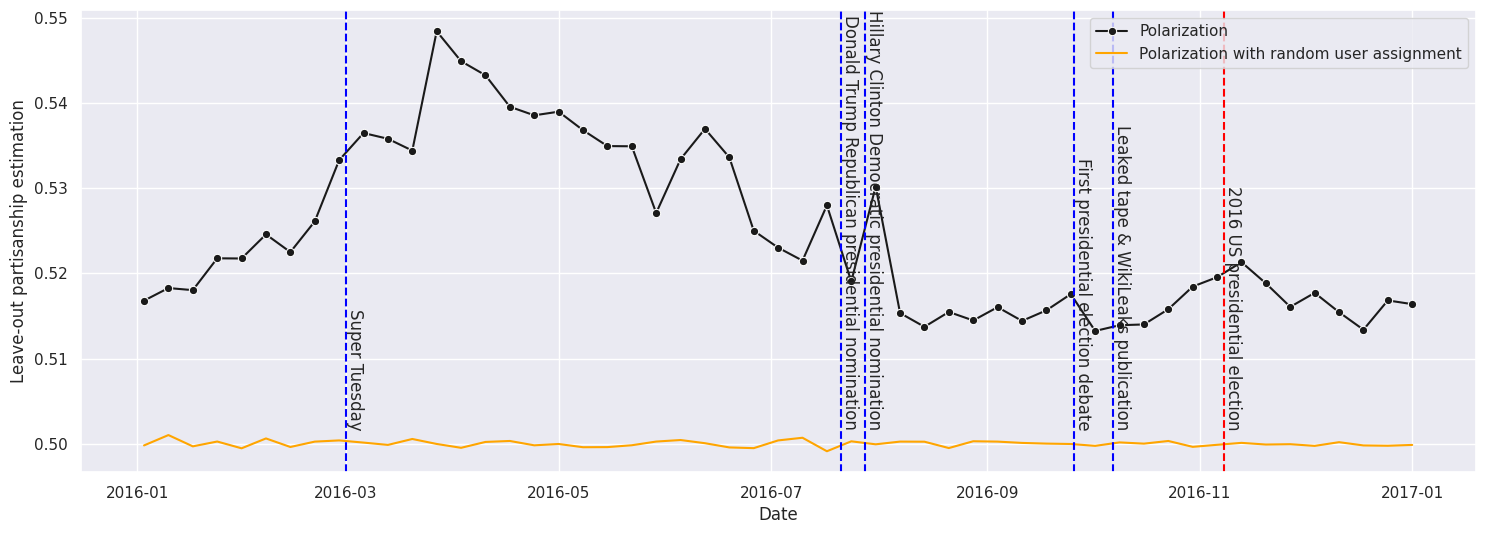

In [10]:
# Plot weekly polarization
plot_polarization_by_time(
    data=pol_by_week_events,
    event_key=EVENT_KEY,
    event_details=EVENT_DETAILS,
    granularity="week",
)

### Daily polarization

In [ ]:
logging.info("Calculating leave-out polarization by day...")

pol_by_day_events = calculate_polarization_by_time(
    event_comments,
    ngram_range=(1, 2),
    event_vocab=event_vocab,
    freq="D",
    equalize_users=True,
)

logging.info("Saving daily polarization data...")
pol_by_day_events.to_parquet(
    f"{OUTPUT_DIR}/{EVENT_KEY}_leaveout_polarization_by_day.parquet",
    index=False,
)


In [ ]:
pol_by_day_events = pd.read_parquet(
    f"{OUTPUT_DIR}/{EVENT_KEY}_leaveout_polarization_by_day.parquet"
)


In [ ]:
# Plot daily polarization

plot_polarization_by_time(
    data=pol_by_day_events,
    event_key=EVENT_KEY,
    event_details=EVENT_DETAILS,
    granularity="day",
)